# Image Classification and Quantization with TensorFlow/TFLite
In this tutorial, we will demonstrate:
1. How to train an image classification model with Keras and TFLite model maker
2. What are different types of quantization and how to quantize our models using TensorFlow

## 1. Building a Image Classifier


### 1.1 TFLite Model Maker

The TensorFlow Lite Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications. 

The following guide is excerpted from [Tensorflow's official guide](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification) and shows an end-to-end example that utilizes this Model Maker library to illustrate the adaptation and conversion of a commonly-used image classification model to classify flowers.

#### 1.1.1 Prerequisites
First, we need to prepare our work environment and install the necessary Python packages.



In [ ]:
pip install -q tflite-model-maker

Next, import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

from PIL import Image
import matplotlib.pyplot as plt

Here, we declare some global constants which will be used later

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
NUM_CLASSES = 102
BATCH_SIZE = 64

QUANTIZED_MODEL_FROM_TMM = 'tflite_model_maker_flower_103_range_[0,1].tflite'
FLOAT_MODEL_FROM_KERAS = 'float_model_flower_103_range_[-1,1].tflite'
POST_TRAIN_QUANTIZED = 'post_train_quantized_flower_103_range_[-1,1].tflite'
QUANTIZE_AWARE_TRAINED = 'quantize_aware_flower_103_range_[-1,1].tflite'

#### 1.1.2 Prepare Datasets

In this Demo, we are going to use the [oxford_flowers102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) dataset. It contains 102 common flower categrories commonly found in the UK.

We are splitting our dataset into Train, Validation and Test datasets.

*   **Training dataset** is used by our classifier during the training process in order to tune its weights so that it could learn to establish the connection between the patterns and labels
*   **Validation dataset** is also used during the training stage to constantly evaluate our model's performance on datasets that do not participate in backpropagation. It helps us to identify whether our model is overfitting our training dataset
*   **Test dataset** is used after training to assess our models generalizability on unseen data

(Note: We are swapping train and test dataset for oxford_flowers102 due to this issue: https://github.com/tensorflow/datasets/issues/3022. After swapping, we have 6149 training images and 1020 test and validation images)



In [ ]:
test_data, val_data, train_data = DataLoader.from_tfds('oxford_flowers102')

In [ ]:
_, ds_info = tfds.load('oxford_flowers102', with_info=True)

In [ ]:
# let's try print out dataset descriptions
print(ds_info.description)

The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).


Let's take a glance at sample images for each class. Oftentimes, understanding the training dataset helps us to assess the difficulties of our task and adjust hyper-parameters accordingly, e.g:
1. Is the dataset balanced?
2. Should we penalize (downweight) certain classes because the pattern is too easy to recognize?
3. Should we award (overweight) correct predictions more between similar looking classes when it's hard to tell the difference visually even for human eyes?

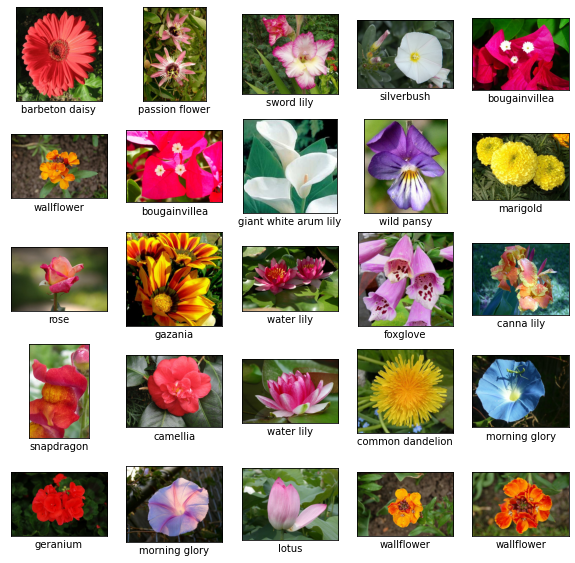

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(train_data.index_to_label[label.numpy()])
plt.show()

#### 1.1.3 Model training

Let's create an image classifier model together. The default model used by TFLite Model Maker ImageClassifier is EfficientNet-Lite0. Here, we see that we only have 130,662 trainable params out of 3.5 millions params in total, that means the weights we transferred from pre-trained backbone are frozen during training. We are only updating the weights of the dense layer (our classification head) for this training process. This is called transfer-learning.


In [ ]:
tflite_model = image_classifier.create(train_data, validation_data=val_data, epochs=30, batch_size=BATCH_SIZE)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 3,543,686
Trainable params: 130,662
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


96/96 [==============================] - 49s 449ms/step - loss: 3.8678 - accuracy: 0.2402 - val_loss: 3.6928 - val_accuracy: 0.2451
Epoch 2/30
96/96 [==============================] - 40s 420ms/step - loss: 2.6884 - accuracy: 0.5524 - val_loss: 2.9024 - val_accuracy: 0.4373
Epoch 3/30
96/96 [==============================] - 41s 431ms/step - loss: 2.1650 - accuracy: 0.6942 - val_loss: 2.4276 - val_accuracy: 0.5980
Epoch 4/30
96/96 [==============================] - 40s 418ms/step - loss: 1.8785 - accuracy: 0.7790 - val_loss: 2.1296 - val_accuracy: 0.6902
Epoch 5/30
96/96 [==============================] - 40s 418ms/step - loss: 1.6940 - accuracy: 0.8294 - val_loss: 1.9302 - val_accuracy: 0.7539
Epoch 6/30
96/96 [==============================] - 40s 417ms/step - loss: 1.5781 - accuracy: 0.8590 - val_loss: 1.7946 - val_accuracy: 0.7814
Epoch 7/30
96/96 [==============================] - 40s 417ms/step - loss: 1.4971 - accuracy: 0.8822 - val_loss: 1.6958 - val_accuracy: 0.8157
Epoch 8/30

After the training is finished, it is time to evaluate our model's performance on unseen test dataset


In [ ]:
loss, accuracy = tflite_model.evaluate(test_data)

32/32 [==============================] - 6s 177ms/step - loss: 1.2956 - accuracy: 0.9186


Alternatively, we could also plot out our predictions on test images to visualize how our model performed:

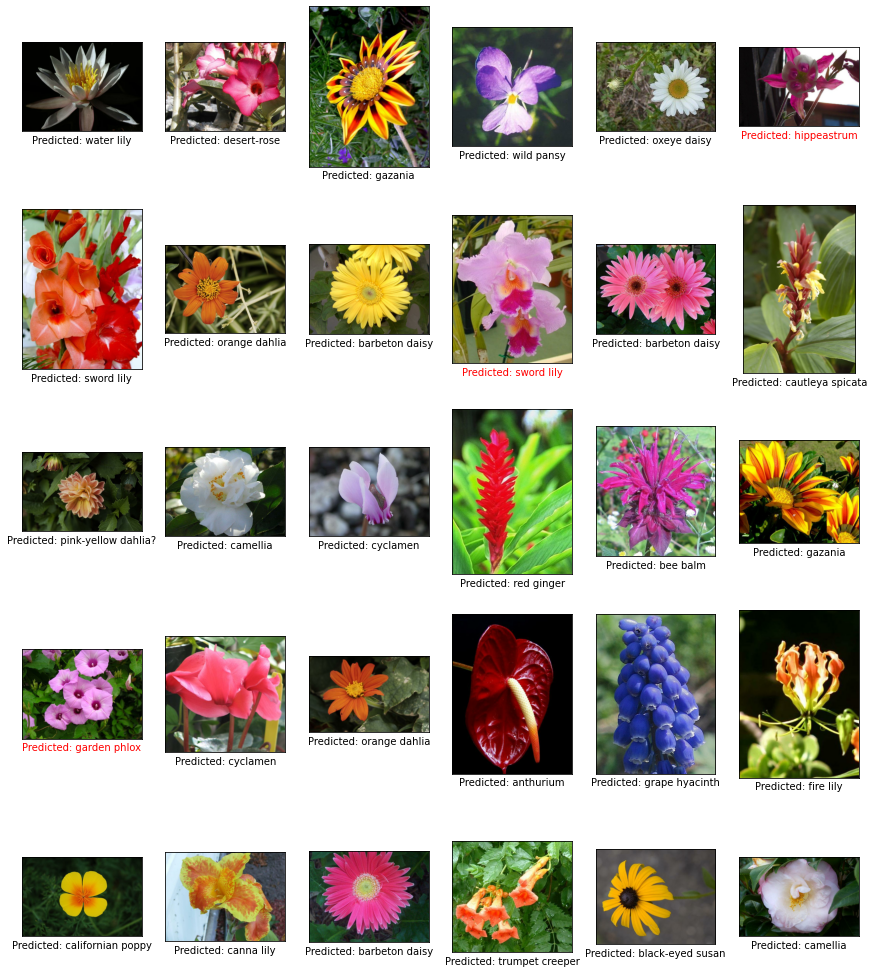

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter match or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 30 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(15, 18))
predicts = tflite_model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(30)):
  ax = plt.subplot(5, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

Not bad! Our accuracy is more than 91%, and from our visualizations it got most of the predictions correct. However, what if we try our model on an image that is not a flower?

--2022-04-19 21:52:10--  https://play-lh.googleusercontent.com/OA9DcLdOtGCWUESkn7Jbc5lBJuPrleroAwL2QX2R3fIXrR-Mkhn1CWitj_ioDZGJ
Resolving play-lh.googleusercontent.com (play-lh.googleusercontent.com)... 74.125.135.119, 2607:f8b0:400e:c01::77
Connecting to play-lh.googleusercontent.com (play-lh.googleusercontent.com)|74.125.135.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7323 (7.2K) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]   7.15K  --.-KB/s    in 0s      

2022-04-19 21:52:10 (56.0 MB/s) - ‘test.jpeg’ saved [7323/7323]



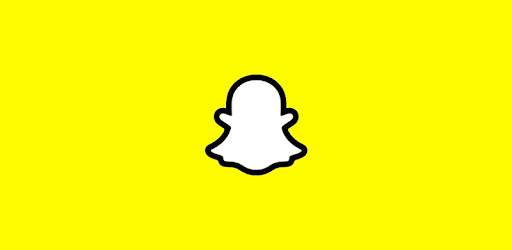

In [ ]:
# Download a sample non-flower image online
!wget -O test.jpeg https://play-lh.googleusercontent.com/OA9DcLdOtGCWUESkn7Jbc5lBJuPrleroAwL2QX2R3fIXrR-Mkhn1CWitj_ioDZGJ
test_img = Image.open("test.jpeg")
display(test_img)

In [ ]:
test_img = np.expand_dims(np.array(test_img, np.float32), 0)
test_img = test_img / 255
test_img.resize(1,224,224,3)
predict = tflite_model.predict_top_k(test_img)
predict[0][0][0]

'pincushion flower'

Ooops, looks like our model is making totally random predictions. This is because it is only trained on flower images and has never seen images of other contents. This is a common challenge we often encounter when training classifiers on a special domain, we will address this question together in the next section.

###1.2 Keras

tf.keras is another high-level API from Tensorflow that helps us to create and train ML models if we want to have more control in building our custom models. We can still use pre-trained weights from different backbones, but we have much more flexibility to control which layers need to be fine-tuned and what loss we want to use. 

In the following section, we will show how to:
1. Add an additional class to existing datasets 
2. Fine-tune pre-trained ImageNet model to our flower classification task
3. Quantize our model using different techniques

#### 1.2.1 Dataset handling
We have seen that our previous model performs badly on non-flower images, what we can do is to add a negative class named `non-flower` using images from ImageNet so that whenever our model sees something that is not a flower, it knows what to predict.

In [ ]:
# let's first create a directory to save all images
IMAGE_FOLDER = "/workspace/datasets/dresses/"
def create_dir(relative_path):
    path = os.path.join("/content", relative_path)
    if not os.path.exists(path):
        os.mkdir(path)
create_dir(IMAGE_FOLDER)

In [ ]:
# load original flower dataset
flower_test, flower_val, flower_train = DataLoader.from_tfds('oxford_flowers102')
data_by_split = {
    "train": flower_train,
    "test": flower_test,
    "val": flower_val
}

In [ ]:
# get number of flower classes
NUM_CLASSES = flower_test.num_classes

# create index to class name mapping
index_to_class = dict(zip(list(range(NUM_CLASSES)),[flower_test.index_to_label[i] for i in range(NUM_CLASSES)]))

# add an additional negaive class for non-flowers
index_to_class[NUM_CLASSES] = 'non-flower'
NUM_CLASSES = NUM_CLASSES + 1

In [ ]:
# create folders for each flower type and non-flower
def create_folders_by_class(data, split):
    split_folder = os.path.join(IMAGE_FOLDER, split)
    create_dir(split_folder)
    for idx, label in index_to_class.items():
        class_folder = os.path.join(split_folder, label)
        create_dir(class_folder)

for split, data in data_by_split.items():
    create_folders_by_class(data, split)

In [ ]:
# next store flower images by class name
def save_flower_dataset(data, split):
    i = 0
    for img, lab in data.gen_dataset().unbatch():
        img = Image.fromarray(img.numpy())
        class_folder = os.path.join(IMAGE_FOLDER, split, data.index_to_label[lab])
        img.save(os.path.join(class_folder, str(i)+".jpeg"))
        i += 1

for split, data in data_by_split.items():
    save_flower_dataset(data, split)

In [ ]:
# save imagenet images to its folder
# (Run this line twice in case download from AWS fails sometimes)
for i in range(2):
    try:
        _, _, imgnet_data = DataLoader.from_tfds('imagenet_v2')
        break
    except Exception as e:
        print(e)

def save_imagenet_dataset():
    i = 0
    split = "train"
    # num of images in train: 50, val: 10, test: 10
    for img, lab in imgnet_data.gen_dataset().unbatch():
        if i >= 50: 
            split = 'val'
        if i >= 60:
            split = 'test'
        if i >= 70:
            break
        dst_path = os.path.join(IMAGE_FOLDER, split, 'non-flower', str(i)+".jpeg")
        img = Image.fromarray(img.numpy())
        img.save(dst_path)
        i += 1

save_imagenet_dataset()

In [ ]:
# when we create datasets from directories, it will sort folder names alphanumerically and use that as training labels,
# therefore we need to reorganize the index to class name mapping so that we could use that later (e.g. in Lens Studio)
labels_reorged = sorted(os.listdir(os.path.join(IMAGE_FOLDER, "val")))
index_to_class = dict(zip(range(NUM_CLASSES), labels_reorged))

In [ ]:
def create_dataset_from_directory(split):
    ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(IMAGE_FOLDER, split),
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = create_dataset_from_directory("train")
val_dataset = create_dataset_from_directory("val")
test_dataset = create_dataset_from_directory("test")

Found 6199 files belonging to 103 classes.
Found 1030 files belonging to 103 classes.
Found 1030 files belonging to 103 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
NUM_TRAIN_IMAGES = ds_info.splits['test'].num_examples

def preprocess(ds, shuffle=False, augment=False):
    # Resize and rescale input images for all datasets.
    # [0, 255] -> [-1, 1]
    ds = ds.map(lambda x, y: (tf.keras.layers.Rescaling(2./255, -1)(x), y), 
                num_parallel_calls=AUTOTUNE)
    # Images of other shapes are padded into square and resized to 224x224
    ds = ds.map(lambda x, y: (tf.image.resize_with_pad(x, IMAGE_HEIGHT, IMAGE_WIDTH), y), 
                num_parallel_calls=AUTOTUNE)

    # Shuffling is especially important on datasets where sequential images are of the same class, 
    # which could let our model stuck in a local minima if it is descending along gradients
    # learnt from a single or similar patterns constantly
    if shuffle:
        ds = ds.shuffle(NUM_TRAIN_IMAGES, seed=123)

    # Use data augmentation only on the training set.
    # This introduces more variability to our training data, 
    # which makes our model more robust to noises
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomZoom([-0.2, 0.2]),                                     
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.4),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets to speed up data loading
    return ds.prefetch(buffer_size=AUTOTUNE)

train_dataset_preprocessed = preprocess(train_dataset, shuffle=True, augment=True)
validation_dataset_preprocessed = preprocess(val_dataset)
test_dataset_preprocessed = preprocess(test_dataset)

#### 1.2.2 Model training


This following code shows how we adapt MobileNetV2 as our backbone and transfer weights pre-trained on ImageNet to our task. Note how we added data augmentation, normalization (in the dataset loading stage above) and dropout (in the model) to make our make our model more robust to noises. In this section, instead of only training the last layer, we freeze first 100 layers (where our model mostly learns to recognize edges and patterns) and let our model fine tune layers afterwards.

In [ ]:
def create_model(image_shape, num_class):
    # We use MobileNetV2 here as our backbone
    backbone = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                include_top=False,
                                                weights='imagenet')

    # Since the model is already pretrained on ImageNet and our task is fairly 
    # simple, we can reuse some of the weights and just fine tune the last few layers
    for layer in backbone.layers[:100]:
        layer.trainable = False

    # create model
    inputs = tf.keras.Input(shape=image_shape)
    x = backbone(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_class)(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
keras_model = create_model(IMG_SHAPE, NUM_CLASSES)
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 103)               131943    
                                                                 
Total params: 2,389,927
Trainable params: 1,993,383
Non-train

Now, it's time to compile and train our model

In [ ]:
EPOCHS = 30
# Default learning rate in TFLite model maker is 0.004
# we are using a much smaller learning rate here to fine-tune our model
INITIAL_LEARNING_RATE = 0.0001
FIRST_DECAY_STEPS = len(train_dataset) * EPOCHS

def loss_fn(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(tf.one_hot(y_true, NUM_CLASSES), 
                                                    tf.expand_dims(y_pred, 1), 
                                                    from_logits=True, 
                                                    label_smoothing = 0.1)

# CosineDecay allows us to reduce our learning rate smoothly as we train more epochs 
optimizer_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(INITIAL_LEARNING_RATE, FIRST_DECAY_STEPS)

keras_model.compile(optimizer=tf.keras.optimizers.Adam(optimizer_schedule),
                    loss=loss_fn,
                    metrics=['accuracy'])

history = keras_model.fit(train_dataset_preprocessed,
                          epochs=EPOCHS,
                          validation_data=validation_dataset_preprocessed)

Epoch 1/30
97/97 [==============================] - 41s 289ms/step - loss: 3.6019 - accuracy: 0.2658 - val_loss: 2.6123 - val_accuracy: 0.4816
Epoch 2/30
97/97 [==============================] - 35s 277ms/step - loss: 1.9473 - accuracy: 0.6791 - val_loss: 1.6933 - val_accuracy: 0.7592
Epoch 3/30
97/97 [==============================] - 35s 273ms/step - loss: 1.4997 - accuracy: 0.8217 - val_loss: 1.4553 - val_accuracy: 0.8311
Epoch 4/30
97/97 [==============================] - 37s 300ms/step - loss: 1.3218 - accuracy: 0.8805 - val_loss: 1.3038 - val_accuracy: 0.8845
Epoch 5/30
97/97 [==============================] - 35s 274ms/step - loss: 1.1979 - accuracy: 0.9201 - val_loss: 1.2499 - val_accuracy: 0.8913
Epoch 6/30
97/97 [==============================] - 34s 272ms/step - loss: 1.1451 - accuracy: 0.9340 - val_loss: 1.2246 - val_accuracy: 0.8990
Epoch 7/30
97/97 [==============================] - 34s 273ms/step - loss: 1.0984 - accuracy: 0.9479 - val_loss: 1.2069 - val_accuracy: 0.8971

Plotting our training/validation losses and accuracies can help us understand whether we are underfitting our overfitting or models and adjust our learning rates and model complexities accordingly. 

In [ ]:
def plot_training_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

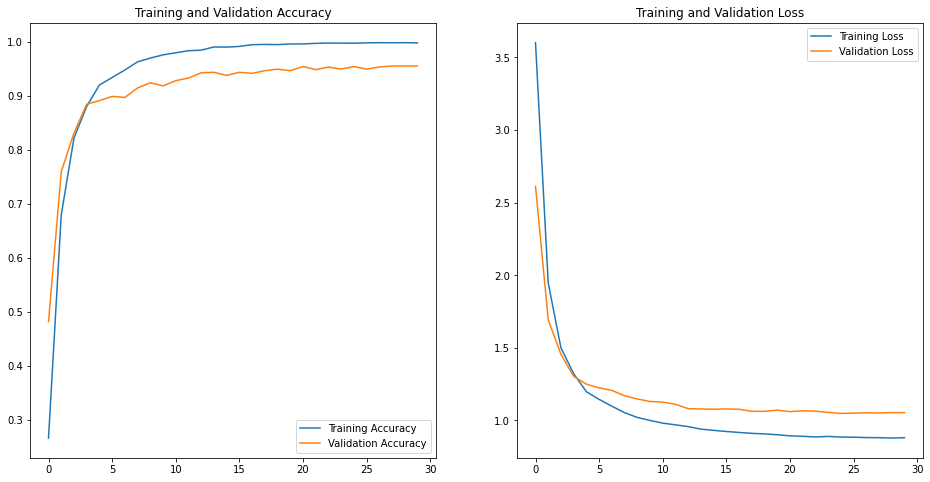

In [ ]:
plot_training_curve(history)

~ 95%, not bad, it is even better than the model we trained using TFLite model maker. Here are some trade-offs between these two approaches: 
1. The default architecture used in TFLite model makers is `efficientNetLite0`, which has around 3.5M parameters while the `MobileNetV2` we used only has 2.4M parameters. Larger networks often have larger capacity so that they could do more complexed tasks. However, they are running slower as well, so we need to find a balance between model accuracy, size and runtime.
2. We are using default hyper-parameters in TFLite ImageClassifier, which were carefully searched and tested to work robustly on many datasets. However, in our own Keras model, our learning rate schedules, losses, normalizations and other hyper-parameters were hand-picked, it might take many experiments or computationally expensive grid-searches to find the optimal configs.

In our case, when training our model using TFLite model maker, we only kept the last FC layer learnable, so it has less freedom to adapt to our task, this may be one of the reasons why our our Keras model performs better.

Now, let's try to export our model, to get prediction probabilities, we need to append a softmax layer at the end of our model.


In [ ]:
def append_softmax(model):
    inputs = tf.keras.Input(shape=(224,224,3))
    x = model(inputs)
    outputs = tf.keras.activations.softmax(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
keras_model = append_softmax(keras_model)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
float_keras_model = converter.convert()
with open(FLOAT_MODEL_FROM_KERAS, 'wb') as f:
    f.write(float_keras_model)

INFO:tensorflow:Assets written to: /tmp/tmp8x0gdjc8/assets


INFO:tensorflow:Assets written to: /tmp/tmp8x0gdjc8/assets


##2. Quantization


###2.1 What is Quantization
Quantization for deep learning is the process of approximating a floating point (normaly 32bits) neural network with lower bit values (16bits or 8bits). This drastically reduces both the memory requirement and computational cost of the network.



###2.2 Different types of quantization

In terms of when the quantization is performed, we can categorize them into two types of quantization: 

1.   **Post-training quantization**
2.   **Quantization aware training**

And in terms of quantization specifications, we have the following choices:

*   **Per-axis** vs **per-tensor**: Per-tensor quantization means that there will be one scale and/or zero-point per entire tensor. Per-axis quantization means that there will be one scale and/or zero point per slice in the quantized dimension. 
*   **Symmetric** vs **asymmetric**: Activations are asymmetric: they can have their zero-point anywhere within the signed int8 range [-128, 127]. Weights are symmetric: forced to have zero-point equal to 0. 
*   **Signed integer** vs **unsigned integer**: TensorFlow Lite quantization will primarily prioritize tooling and kernels for int8 quantization for 8-bit. This is for the convenience of symmetric quantization being represented by zero-point equal to 0.

####2.2.1 Post Training Quantization
Post Training quantization requires a representative dataset to estimate the range, i.e, (min, max) of all floating-point tensors in the model so that we can establish a better mapping from floating point to integer space. 


In [ ]:
keras_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 103)               2389927   
                                                                 
 tf.nn.softmax (TFOpLambda)  (None, 103)               0         
                                                                 
Total params: 2,389,927
Trainable params: 1,993,383
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
def representative_dataset():
    for data, label in train_dataset_preprocessed.take(30):
        yield [np.array(data, dtype=np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
post_train_quantized_model = converter.convert()

with open(POST_TRAIN_QUANTIZED, 'wb') as f:
    f.write(post_train_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpe04gqhlv/assets


INFO:tensorflow:Assets written to: /tmp/tmpe04gqhlv/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


####2.2.2 Quantization Aware Training

Quantization aware training simulates the lower precision behavior in the forward pass of the training process. This introduces the quantization errors as part of the training loss, which the optimizer tries to minimize during the training. Thus, QAT helps in modeling the quantization errors during training and mitigates its effects on the accuracy of the model at deployment.

In this experiment, notice that we do not freeze any layers, that means all the weights will be modified during training.

In [ ]:
import tensorflow_model_optimization as tfmot
from keras import backend as K 

# quantize backbone
backbone = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
q_backbone = tfmot.quantization.keras.quantize_model(backbone)

# quantize classification head
head_model = tf.keras.models.Sequential([
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.GlobalAveragePooling2D()),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dropout(0.2)),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(NUM_CLASSES))
])
head_model.build(q_backbone.layers[-1].output_shape)
q_head = tfmot.quantization.keras.quantize_apply(head_model)

# build quantize model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = q_backbone(inputs)
outputs = q_head(x)
q_aware_model = tf.keras.Model(inputs, outputs)
q_aware_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2278138   
 ional)                                                          
                                                                 
 sequential_2 (Sequential)   (None, 103)               131955    
                                                                 
Total params: 2,410,093
Trainable params: 2,355,815
Non-trainable params: 54,278
_________________________________________________________________


In [ ]:
EPOCHS = 35
INITIAL_LEARNING_RATE = 0.0001
FIRST_DECAY_STEPS = len(train_dataset) * 45

optimizer_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(INITIAL_LEARNING_RATE, FIRST_DECAY_STEPS)
q_aware_model.compile(tf.keras.optimizers.Adam(optimizer_schedule),
                      loss=loss_fn,
                      metrics=['accuracy'])

In [ ]:
history = q_aware_model.fit(train_dataset_preprocessed,
                            epochs=EPOCHS,
                            validation_data=validation_dataset_preprocessed)

Epoch 1/35
97/97 [==============================] - 78s 586ms/step - loss: 3.5347 - accuracy: 0.3050 - val_loss: 4.0412 - val_accuracy: 0.1408
Epoch 2/35
97/97 [==============================] - 62s 560ms/step - loss: 1.9310 - accuracy: 0.7037 - val_loss: 3.1954 - val_accuracy: 0.3117
Epoch 3/35
97/97 [==============================] - 62s 560ms/step - loss: 1.4265 - accuracy: 0.8490 - val_loss: 2.5601 - val_accuracy: 0.4767
Epoch 4/35
97/97 [==============================] - 62s 559ms/step - loss: 1.2301 - accuracy: 0.9066 - val_loss: 2.2718 - val_accuracy: 0.5786
Epoch 5/35
97/97 [==============================] - 62s 558ms/step - loss: 1.1200 - accuracy: 0.9398 - val_loss: 1.9218 - val_accuracy: 0.6738
Epoch 6/35
97/97 [==============================] - 62s 556ms/step - loss: 1.0639 - accuracy: 0.9558 - val_loss: 1.7092 - val_accuracy: 0.7573
Epoch 7/35
97/97 [==============================] - 62s 558ms/step - loss: 1.0325 - accuracy: 0.9647 - val_loss: 1.5877 - val_accuracy: 0.7932

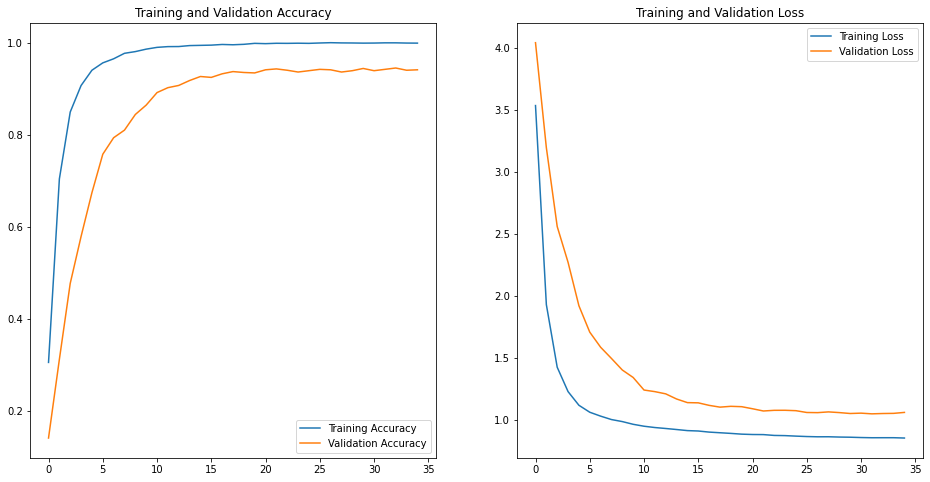

In [ ]:
plot_training_curve(history)

In [ ]:
q_aware_model = append_softmax(q_aware_model)
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

with open(QUANTIZE_AWARE_TRAINED, 'wb') as f:
    f.write(quantized_aware_model)

INFO:tensorflow:Assets written to: /tmp/tmppqo7kvn7/assets


INFO:tensorflow:Assets written to: /tmp/tmppqo7kvn7/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## Compare models

### 3.1 Comparing accuracy

In [ ]:
test_images = []
test_labels = []
for batch in list(test_dataset_preprocessed):
    test_images.append(batch[0])
    test_labels.append(batch[1])
    
test_images = np.vstack(test_images)
test_labels = np.hstack(test_labels)

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(test_images)))

In [ ]:
evaluate_model(FLOAT_MODEL_FROM_KERAS, model_type="Float")

Float model accuracy is 93.1068% (Number of test samples=1030)


In [ ]:
evaluate_model(POST_TRAIN_QUANTIZED, model_type="Post-training Quantized")

Post-training Quantized model accuracy is 93.3981% (Number of test samples=1030)


In [ ]:
evaluate_model(QUANTIZE_AWARE_TRAINED, model_type="Quantize-Aware Trained")

Quantize-Aware Trained model accuracy is 93.1068% (Number of test samples=1030)


We can see that both quantization measures barely had any accuracy drops (our Post-Quantized model surprisingly did better). But this actually do mean that there will be numerically mismatches when we quantize our models after training. For tasks like classification, this impact may be minimal, but for other more complex tasks like image-to-image translations, it may jeopardize visual qualities a lot. 

When comparing these two quantization options, there are also some trade-offs between them:

- Post training quantization is easier to use because it does not require retraining (however, it does need training samples to calculate appropriate scales and biases to quantize the weights)
- Quantize aware training minimizes quantization loss and often have less numerical mismatches at inference time compared with training time. But it takes longer as we need to retrain the model with quantization loss included

### 3.2 Comparing size
Next, we can also compare size differences between float and 8-bit quantized model:

In [ ]:
!ls -hl | grep .*tflite

-rw-r--r-- 1 root root 9.0M Apr 19 22:39 float_model_flower_103_range_[-1,1].tflite
-rw-r--r-- 1 root root 2.8M Apr 19 22:43 post_train_quantized_flower_103_range_[-1,1].tflite
-rw-r--r-- 1 root root 2.8M Apr 19 23:22 quantize_aware_flower_103_range_[-1,1].tflite


We see that `float_model.tflite` is 9.0MB and `post_training_quantized_model.tflite` and `quantize_aware_model.tflite` are only 2.8MB.

### 3.3 Evaluate on non-flower images
Now it is time too see if retraining our model with a negative class included in our dataset will help us to make better predictions on non-flower images

In [ ]:
index_to_class[np.argmax(keras_model.predict(test_img))]

Nice, looks like our model finally learnt how to distinguish non-flower images as well! 

## Export and Download

If you are running this sample notebook in Colab, you can use the following code to download the TFLite models we trained so that we can import it into Lens Studio. The `[0,1]` or `[-1,1]` range specified in the name means that the model is expecting inputs normalized to values between 0 and 1 (0r -1 to 1).

If we are reading pixel values between 0 and 255 (which our Lens Studio does), we need to apply certain scales and biases matching the preprocessing steps we took during training so that we ensure data fed into our model are within consistent ranges:
1. `[0,255] -> [0,1]`: scale is `1/255`, bias is `0`
2. `[0,255] -> [-1,1]`: scale is `2/255`, bias is `-1`

In [ ]:
from google.colab import files

files.download(POST_TRAIN_QUANTIZED)
files.download(QUANTIZE_AWARE_TRAINED)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In order to use the `index_to_class` mapping in our Lens Studio projects, we can dump it either as text or json file, and later copy that into Studio scripts so that we could establish the mapping between prediction label and class names

In [ ]:
import json

with open("index_to_class.json", "w") as f:
    json.dump(index_to_class, f, indent=2)

files.download("index_to_class.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>